<a href="https://colab.research.google.com/github/atheendre130505/gans_monet/blob/main/monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile, os

for fname in ['photo.zip', 'monet.zip']:
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
print(os.listdir('/content/dataset'))


['monet_jpg', 'photo_jpg']


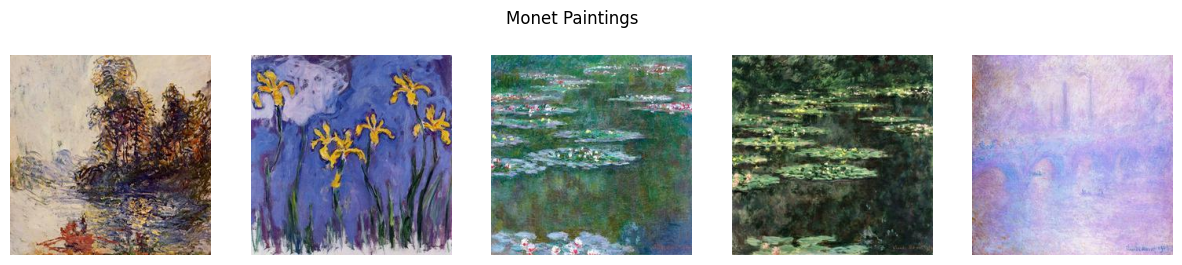

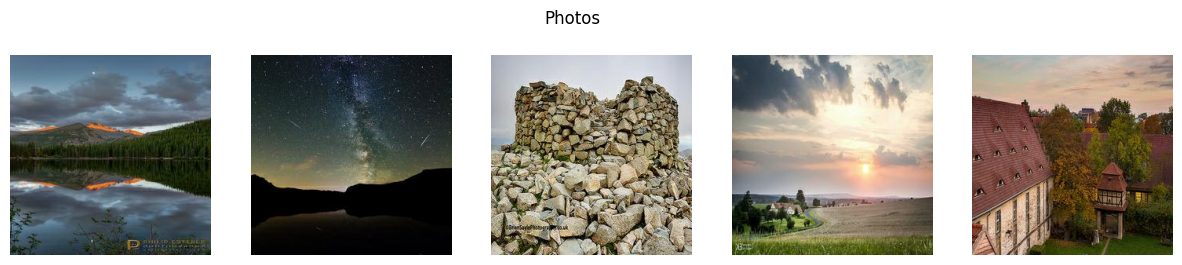

In [2]:
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob

monet_paths = glob('/content/dataset/monet_jpg/*')
photo_paths = glob('/content/dataset/photo_jpg/*')

def show_samples(img_paths, title, n=5):
    plt.figure(figsize=(15,3))
    for i, path in enumerate(random.sample(img_paths, n)):
        img = cv2.imread(path)[:,:,::-1]
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(monet_paths, "Monet Paintings")
show_samples(photo_paths, "Photos")


In [3]:
# Build on your existing code
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create custom dataset class for Monet images
class MonetDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image


In [4]:
# Build on your existing code
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create custom dataset class for Monet images
class MonetDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Input: latent_dim
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),

            # Upsampling layers
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, img_channels, 4, 2, 1),  # 256x256
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: 256x256x3
            nn.Conv2d(img_channels, 16, 4, 2, 1),   # 128x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, 4, 2, 1),             # 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1),             # 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),            # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),           # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, img):
        return self.model(img)


In [7]:
# Initialize models and optimizers
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training function
def train_gan(generator, discriminator, dataloader, num_epochs=100):
    for epoch in range(num_epochs):
        for i, real_imgs in enumerate(dataloader):
            batch_size = real_imgs.size(0)

            # Create labels
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            optimizer_D.zero_grad()

            # Real images
            real_output = discriminator(real_imgs)
            real_loss = criterion(real_output, real_labels)

            # Fake images
            z = torch.randn(batch_size, latent_dim)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs.detach())
            fake_loss = criterion(fake_output, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            fake_output = discriminator(fake_imgs)
            g_loss = criterion(fake_output, real_labels)  # Want discriminator to think fake is real
            g_loss.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')


In [8]:
def generate_monet_images(generator, num_images=10000):
    generator.eval()
    generated_images = []

    with torch.no_grad():
        for i in range(0, num_images, 100):  # Generate in batches
            batch_size = min(100, num_images - i)
            z = torch.randn(batch_size, latent_dim)
            fake_imgs = generator(z)
            generated_images.extend(fake_imgs)

    return generated_images

# Save images for submission
def save_generated_images(images, output_dir):
    for i, img in enumerate(images):
        # Convert from [-1, 1] to [0, 255]
        img = (img + 1) * 127.5
        img = img.clamp(0, 255).byte()
        # Save as PNG
        save_image(img, f'{output_dir}/generated_{i:05d}.png')


In [9]:
# Connect to your existing data loading
from PIL import Image
import torch
from torch.utils.data import DataLoader

# Create dataset from your existing monet_paths
monet_dataset = MonetDataset(monet_paths, transform=transform)
dataloader = DataLoader(monet_dataset, batch_size=32, shuffle=True, num_workers=2)

# Verify data loading
print(f"Dataset size: {len(monet_dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Test one batch
sample_batch = next(iter(dataloader))
print(f"Batch shape: {sample_batch.shape}")


Dataset size: 300
Number of batches: 10
Batch shape: torch.Size([32, 3, 256, 256])


In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move models to device
generator = Generator(latent_dim=100).to(device)
discriminator = Discriminator().to(device)

print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

# Start training with initial parameters
train_gan(generator, discriminator, dataloader, num_epochs=50)


Using device: cpu
Generator parameters: 2,352,595
Discriminator parameters: 714,929
Epoch [0/50], Step [0/10], D Loss: 1.4287, G Loss: 0.5408
Epoch [1/50], Step [0/10], D Loss: 1.3949, G Loss: 0.5583
Epoch [2/50], Step [0/10], D Loss: 1.4610, G Loss: 0.4991
Epoch [3/50], Step [0/10], D Loss: 1.4263, G Loss: 0.5448
Epoch [4/50], Step [0/10], D Loss: 1.4336, G Loss: 0.5413
Epoch [5/50], Step [0/10], D Loss: 1.4093, G Loss: 0.5466
Epoch [6/50], Step [0/10], D Loss: 1.4360, G Loss: 0.5398
Epoch [7/50], Step [0/10], D Loss: 1.5095, G Loss: 0.4917
Epoch [8/50], Step [0/10], D Loss: 1.4545, G Loss: 0.5082
Epoch [9/50], Step [0/10], D Loss: 1.4803, G Loss: 0.5210
Epoch [10/50], Step [0/10], D Loss: 1.4252, G Loss: 0.5327
Epoch [11/50], Step [0/10], D Loss: 1.4259, G Loss: 0.5665
Epoch [12/50], Step [0/10], D Loss: 1.4629, G Loss: 0.5342
Epoch [13/50], Step [0/10], D Loss: 1.4630, G Loss: 0.5429
Epoch [14/50], Step [0/10], D Loss: 1.4464, G Loss: 0.5402
Epoch [15/50], Step [0/10], D Loss: 1.463

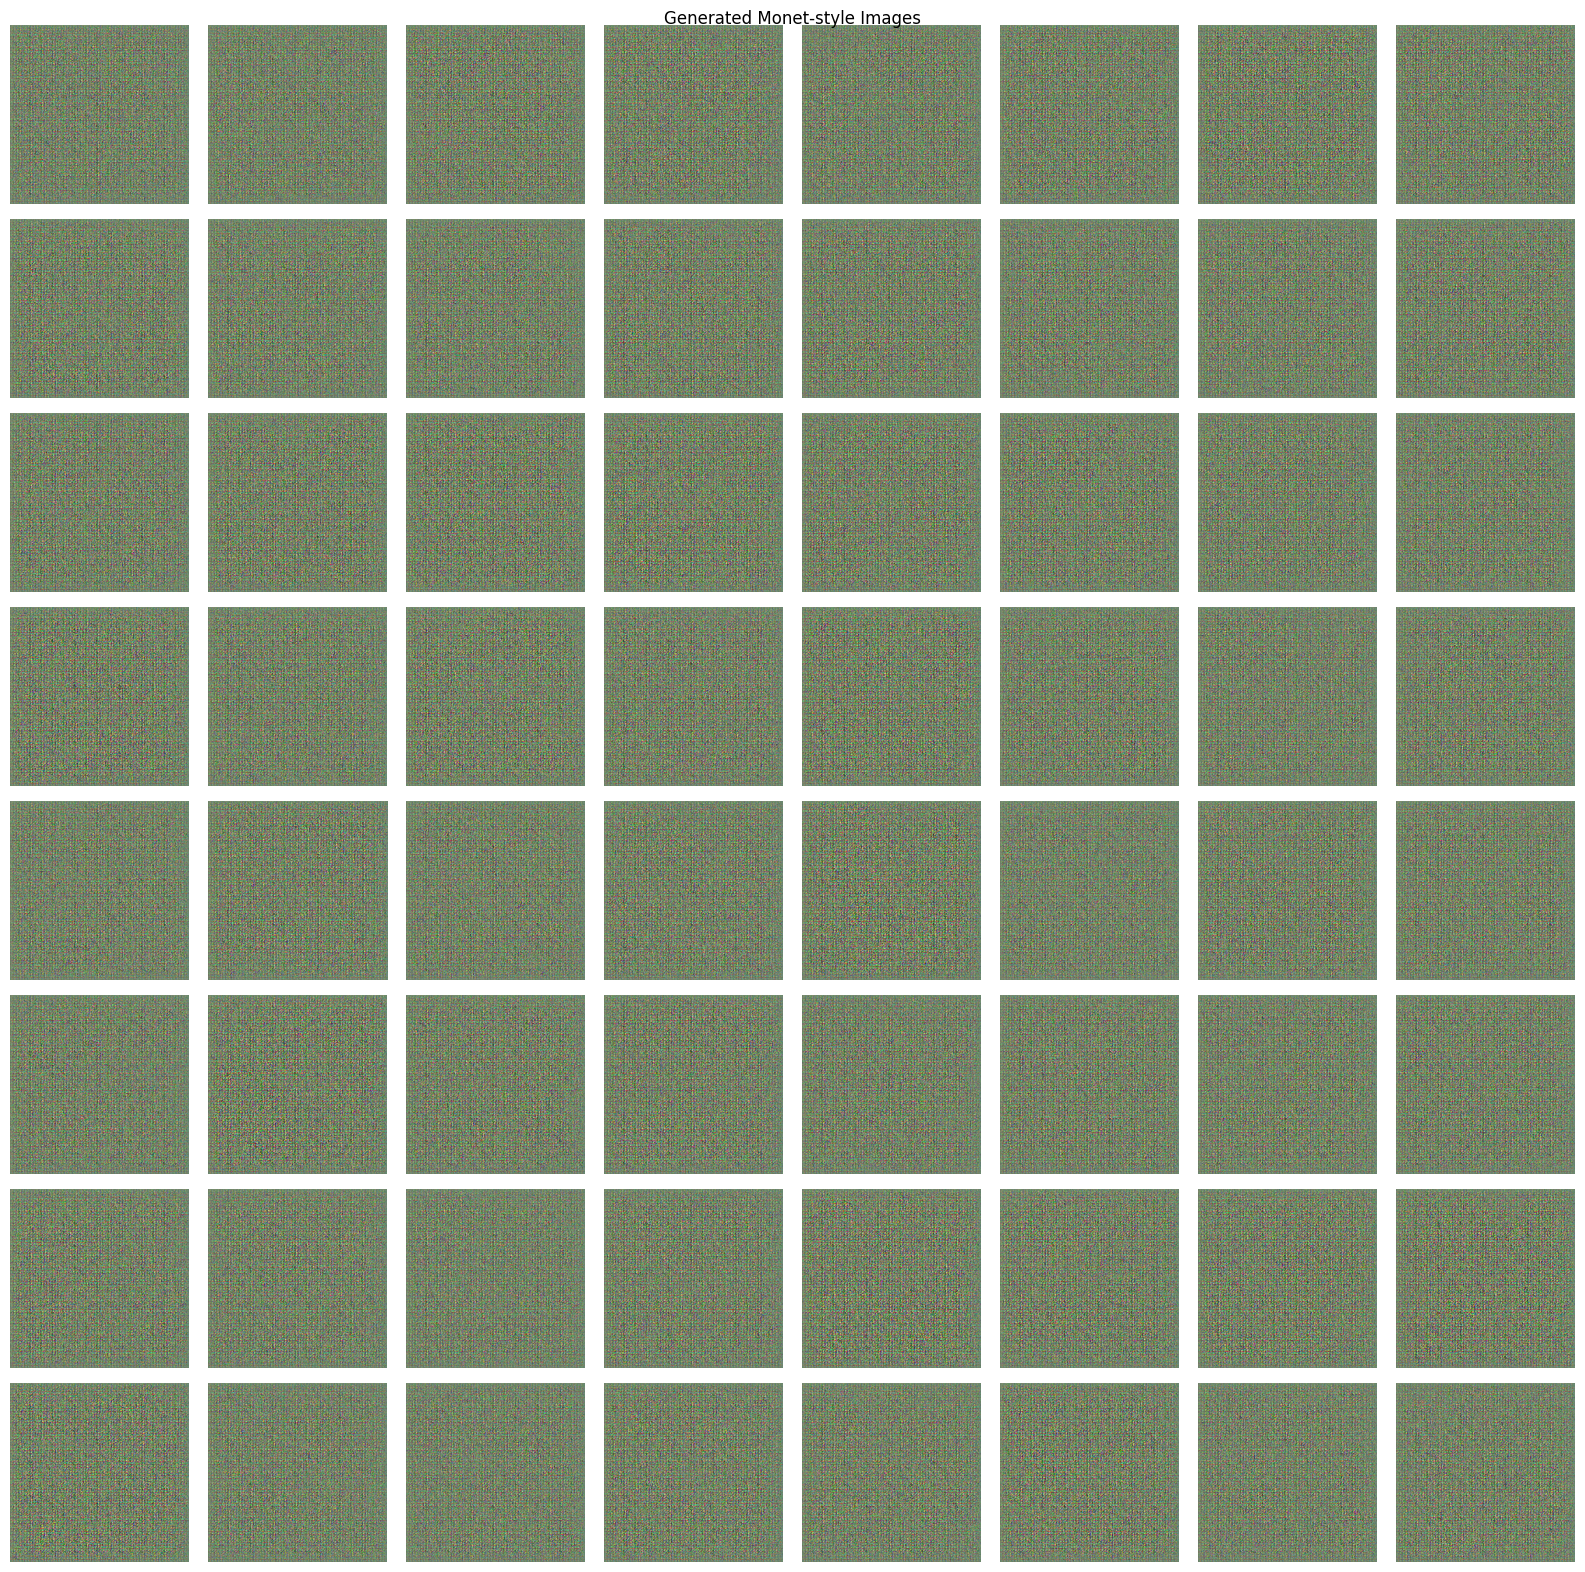

In [11]:
# Generate final samples
def evaluate_generator(generator, num_samples=64):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        fake_imgs = generator(z)

        # Create grid visualization
        fig, axes = plt.subplots(8, 8, figsize=(16, 16))
        for idx, ax in enumerate(axes.flatten()):
            img = fake_imgs[idx].cpu()
            img = (img + 1) / 2  # Denormalize
            ax.imshow(img.permute(1, 2, 0))
            ax.axis('off')
        plt.suptitle('Generated Monet-style Images')
        plt.tight_layout()
        plt.show()

evaluate_generator(generator)
